---

[181031 - AMS] This notebook classifies audio tracks by artist. It requires feature dictionaries as inputs, these can be created using the ExtractFeatures.ipynb notebook

---

In [1]:
# general libraries:
import pickle
import glob
import numpy as np
import pylab as plt
import itertools
import multiprocessing

In [2]:
# scikit-learn libraries:
import sklearn
from sklearn import svm
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_validate
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier

---

Before we do anything we need to define some functions to use later:


In [3]:
def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [4]:
def prepare_data(all_data_in):
    
    all_features=[]
    all_artists=[]
    
    # Create lists of song names and features for each artist:
    for artist in all_data_in: 
        
        # load in the feature dictionary for the artist:
        data=load_obj(artist.replace('.pkl',''))
        print('loading {0}'.format(artist))
        
        songname=[] # will be a list of song names
        songfeat=[] # will be a list of dictionaries containing the feature data
        artists=[]  # will be a list of artists
        
        # extract out the features, song name and artist into separate lists:
        for song in data: 
            songfeat.append(data[song]) 
            songname.append(song)
            artists.append(artist.replace('_data.pkl','').replace('all_','').replace(path,'').replace('_data_testsplit.pkl','').replace('_data_trainsplit.pkl',''))

        # =========
        # if we wanted to modify the features, this would be a good place.
        # for example if we wanted to remove some features, e.g.
        #
        #print (len(songfeat[0]))
        #for i in range(len(songfeat)):
        #    for k in ['onset_a','onset_std','bpm','centroid_a','centroid_std','polyfeat_a','polyfeat_std','zcr_a','zcr_std']:
        #        songfeat[i].pop(k,None)
        #
        #print (len(songfeat[0]))
        # =========
        
        # make a list of the feature names:
        feature_names=list(songfeat[0].keys()) 
        
        # make a list all the feature values for this artist:
        features=[] 
        for i in range(len(songfeat)):
            features.append(list(songfeat[i].values())) 
            
        # append the feature values for this artist into a master list:
        all_features+=features
        
        # append the artist name for this artist into a master list:
        all_artists+=artists
        
    return all_features, all_artists, feature_names

---

Now we can start the main program...

First we define the path to all the saved dictionaries of features:

In [5]:
path='./data_5band/'

Then we get a list of all the dictionaries in that directory:

In [6]:
all_data=glob.glob(path+'/*_data.pkl')

We can load in each dictionary file using the **prepare_data()** function that we defined above:

In [7]:
all_features, all_artists, feature_names = prepare_data(all_data) 

loading ./data_5band\all_AvrilLavigne_data.pkl
loading ./data_5band\all_BoardsOfCanada_data.pkl
loading ./data_5band\all_Classical_data.pkl
loading ./data_5band\all_FooFighters_data.pkl
loading ./data_5band\all_ImogenHeap_data.pkl
loading ./data_5band\all_MichaelJackson_data.pkl
loading ./data_5band\all_PinkFloyd_data.pkl
loading ./data_5band\all_REM_data.pkl
loading ./data_5band\all_TaylorSwift_data.pkl
loading ./data_5band\all_TheFlashbulb_data.pkl
loading ./data_5band\all_TommyEmmanuel_data.pkl
loading ./data_5band\all_Xmas_data.pkl
loading ./data_5band\all_Zero7_data.pkl


Whatever form of machine learning we end up using we're going to need to split our input data into:

* training data (to train our machine learning algorithm)
* test data (to test how well the training worked)

Let's start by taking 90% of the data for training:

In [8]:
train_percent=0.9
test_percent=0.1

We can then use the sklearn function **train_test_split** to randomly divide the full dataset for us:

In [9]:
features_train, features_test, artists_train, artists_test = train_test_split(all_features, all_artists, train_size=train_percent, test_size=test_percent, random_state=0, stratify=all_artists)

One quick check to make sure nothing crazy happened to mess up our data structures:

In [10]:
try:
    if len(artists_test)==len(features_test) and len(artists_train)==len(features_train):
        print("looking good!")
except:
    print('artists and features are not same length: {0} != {1}',format(artists_test,features_test,artists_train,features_train))

looking good!


In [11]:
feature_names_flatten=np.array(feature_names).flatten()
feature_names=np.transpose(feature_names)

Some classifiers require the target classes to be numbered labels, not strings like our artist names currently are. So here we'll do a little bit of pre-processing to format the data. We do this separately for the training and test data.

First the test data:

In [12]:
# convert lists to numpy arrays for test data:
X_test = np.array(features_test)
Y_test = np.array(artists_test)

# call the label encoder from scikit learn:
le = preprocessing.LabelEncoder()

# apply it to the list of artist names:
le.fit(Y_test)
Y_test_n=le.transform(Y_test)

Then repeat for the training data:

In [13]:
X_train = np.array(features_train)
Y_train = np.array(artists_train)
le = preprocessing.LabelEncoder()
le.fit(Y_train)
Y_train_n=le.transform(Y_train)

Finally, let's take a quick look at what our target classes are: 

In [14]:
names=np.unique(Y_test)
print(names)

['./data_5band\\AvrilLavigne' './data_5band\\BoardsOfCanada'
 './data_5band\\Classical' './data_5band\\FooFighters'
 './data_5band\\ImogenHeap' './data_5band\\MichaelJackson'
 './data_5band\\PinkFloyd' './data_5band\\REM' './data_5band\\TaylorSwift'
 './data_5band\\TheFlashbulb' './data_5band\\TommyEmmanuel'
 './data_5band\\Xmas' './data_5band\\Zero7']


---

The first type of machine learning we'll try out is a **neural network classifier**. The neural network requies that we normalise the feature values and subtract the mean. Just to make sure we don't break anything we'll make a copy of our training and test datasets just for the neural network (nn).

In [15]:
nn_features_train=X_train
nn_features_test=X_test

Now let's perform the normalisation using the sklearn **StandardScaler** class:

In [16]:
scaler = StandardScaler()
scaler.fit(features_train)
nn_features_train = scaler.transform(nn_features_train)
nn_features_test = scaler.transform(nn_features_test)

Now we can train the neural network. **lsize** sets the number of nodes - if you don't know what value to use you might want to make a loop over different values and look at how the accuracy changes.

In [17]:
lsize = 5000
nn=MLPClassifier(hidden_layer_sizes=(lsize, ),solver='adam',max_iter=2000)

# train the network:
nn.fit(nn_features_train, artists_train)

# test the network:
nn_pred=nn.predict(nn_features_test)

...and examine the results:

In [18]:
print('--'*30)
print('MLP nn classifier with {0} hidden layers'.format(lsize))
print(classification_report(artists_test, nn_pred,target_names=names))
print('--'*30)

------------------------------------------------------------
MLP nn classifier with 5000 hidden layers
                             precision    recall  f1-score   support

  ./data_5band\AvrilLavigne       0.43      0.33      0.38         9
./data_5band\BoardsOfCanada       0.52      0.55      0.53        22
     ./data_5band\Classical       0.90      0.91      0.91        47
   ./data_5band\FooFighters       0.50      0.70      0.58        10
    ./data_5band\ImogenHeap       0.83      0.83      0.83         6
./data_5band\MichaelJackson       0.71      0.83      0.77         6
     ./data_5band\PinkFloyd       1.00      0.64      0.78        11
           ./data_5band\REM       0.62      0.45      0.53        11
   ./data_5band\TaylorSwift       0.54      0.70      0.61        10
  ./data_5band\TheFlashbulb       0.84      0.91      0.87        56
 ./data_5band\TommyEmmanuel       1.00      0.73      0.84        11
          ./data_5band\Xmas       0.61      0.59      0.60        32

---

The second type of machine learning we'll try is a **random forest classifier**.

To start with we need to build a forest:

In [19]:
n_estimators=1000 # number of trees
forest = RandomForestClassifier(n_estimators=n_estimators, random_state=2, class_weight='balanced')

Then we train it using our training data:

In [20]:
forest.fit(features_train, artists_train)

RandomForestClassifier(class_weight='balanced', n_estimators=1000,
                       random_state=2)

and we test how well the training worked by using our test data. We can evaluate the testing by calculating the accuracy of the prediction given that we know the true target classes for each test data point:

In [21]:
artists_pred = forest.predict(features_test)
accuracy_before=(accuracy_score(artists_test, artists_pred))
print('initial accuracy: {0:.2f}'.format(accuracy_before))

initial accuracy: 0.76


78% accuracy isn't terrible, but it's also not great in machine learning terms. We can try to improve it by pruning out some of the nuisance features. This is a two step process, so we'll string the steps into a short pipeline.

In [22]:
#lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(features_train, artists_train)
rfc = RandomForestClassifier(n_estimators=n_estimators, random_state=2)

pipeline = Pipeline([
    ('feature_selection', SelectFromModel(rfc)),
    ('classification', RandomForestClassifier(n_estimators=n_estimators, random_state=2, class_weight='balanced'))
])

Now let's repeat the training step and check our accuracy again:

In [23]:
pipeline.fit(features_train, artists_train)
    
artists_important_pred = pipeline.predict(features_test)
accuracy_after=(accuracy_score(artists_test, artists_important_pred))
print('new accuracy: {0:.2f}'.format(accuracy_after))

new accuracy: 0.78


We can compare the outputs and check the other metrics:

In [24]:
print('accuracy before pruning features: {0:.2f}'.format(accuracy_before))
print('accuracy after pruning features: {0:.2f}'.format(accuracy_after))
print('We should check other metrics for a full picture of this model:')
print('--'*30)
print('Random Forest report after feature pruning:')
print(classification_report(artists_test, artists_important_pred,target_names=names))
print('--'*30)

accuracy before pruning features: 0.76
accuracy after pruning features: 0.78
We should check other metrics for a full picture of this model:
------------------------------------------------------------
Random Forest report after feature pruning:
                             precision    recall  f1-score   support

  ./data_5band\AvrilLavigne       0.80      0.89      0.84         9
./data_5band\BoardsOfCanada       0.71      0.55      0.62        22
     ./data_5band\Classical       0.96      0.96      0.96        47
   ./data_5band\FooFighters       0.67      0.60      0.63        10
    ./data_5band\ImogenHeap       1.00      0.67      0.80         6
./data_5band\MichaelJackson       1.00      0.83      0.91         6
     ./data_5band\PinkFloyd       0.78      0.64      0.70        11
           ./data_5band\REM       0.80      0.36      0.50        11
   ./data_5band\TaylorSwift       0.89      0.80      0.84        10
  ./data_5band\TheFlashbulb       0.78      0.91      0.84     

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


We can use importance ranking to prune the least useful features. 

In [25]:
clf = pipeline.steps[1][1] 

importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],axis=0)
indices = np.argsort(importances)[::-1]
    
feature_names_importanceorder_pruned=[]
for f in range(len(indices)):
    feature_names_importanceorder_pruned.append(str(feature_names[indices[f]]))

Let's plot them up:

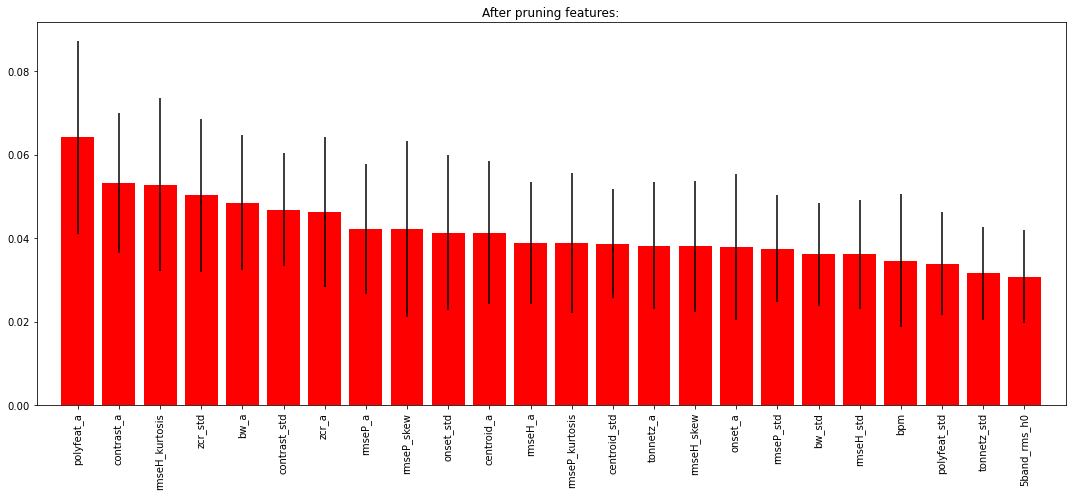

In [33]:
plt.figure(figsize=(15, 7))
plt.title('After pruning features:')
plt.bar(range(len(indices)), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(len(indices)), indices)
plt.xlim([-1, len(indices)])
plt.xticks(range(len(indices)), feature_names_importanceorder_pruned, rotation='vertical')
plt.tight_layout()
plt.show()

In [27]:
no_features=len(feature_names_importanceorder_pruned)

print('Started with {0} features, now using {1}'.format(len(feature_names), no_features))
#print('features used were:')
#print( set(feature_names_flatten)-set(feature_names_importanceorder_pruned) )

Started with 55 features, now using 24


Another good way to visualise the success of the classification is to make a confusion matrix. Here is a function to print a confusion matrix:

In [28]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Showing normalized confusion matrix")
    else:
        print('Showing confusion matrix, without normalization')
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    return

Let's call the function, comparing our test data with the machine learning prediction:

In [29]:
cnf_matrix = confusion_matrix(artists_test, artists_important_pred)

and plot it up:

Showing confusion matrix, without normalization


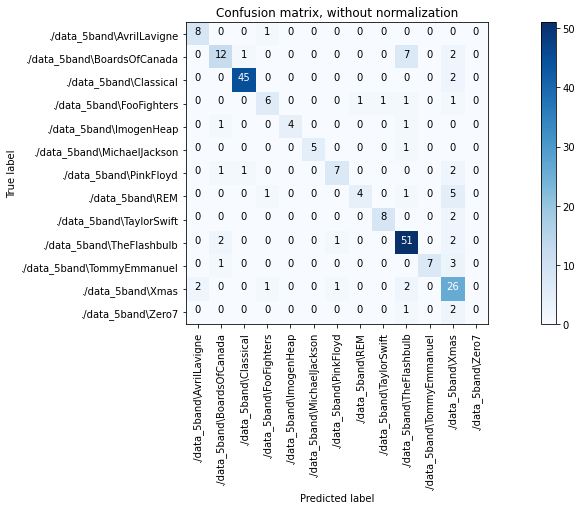

In [32]:
np.set_printoptions(precision=2)

plt.figure(figsize=(15, 7))
plot_confusion_matrix(cnf_matrix, classes=names,
                        title='Confusion matrix, without normalization')
  
# ===
# alternatively you could plot the normalized confusion matrix #
#plt.figure()
#plot_confusion_matrix(cnf_matrix, classes=names, normalize=True,
#                      title='Normalized confusion matrix')
# ===

plt.show()